# Projet 7 - Modèle de scoring crédit

L'objectif est de construire un modèle de classification binaire pour prédire si un client va faire défaut sur son crédit.

**Particularité du projet** : on n'optimise pas l'accuracy mais un **coût métier asymétrique** :
- **FN (faux négatif)** = client qui fait défaut mais qu'on a accepté → coût de **10**
- **FP (faux positif)** = bon client qu'on refuse → coût de **1**

Cette asymétrie reflète la réalité bancaire : accorder un crédit à quelqu'un qui ne rembourse pas coûte bien plus cher (perte du capital) que de refuser un bon client (manque à gagner sur les intérêts).

## 1. Chargement des données

On charge les fichiers parquet issus du feature engineering :
- `X_train_fe.parquet` : 307 511 clients × 805 features
- `y_train.parquet` : variable cible TARGET (1 = défaut, 0 = remboursé)
- `X_test_fe.parquet` : données de test pour Kaggle

Le taux de défaut est d'environ 8%, donc on a un **déséquilibre de classes** à prendre en compte.

### Chargement des données et import des bibliothèques

On importe les librairies nécessaires et on charge les fichiers `X_train_fe.parquet`, `y_train.parquet` et `X_test_fe.parquet`.  
Cette cellule initialise également les chemins et affiche un premier aperçu des dimensions et du default rate.

In [1]:
# imports + charge X_train_fe, y_train, X_test_fe

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score

# Chemins
OUTPUT_DIR = Path("./outputs").resolve()
X_train_path = OUTPUT_DIR / "X_train_fe.parquet"
y_train_path = OUTPUT_DIR / "y_train.parquet"
X_test_path  = OUTPUT_DIR / "X_test_fe.parquet"

# Chargement
X = pd.read_parquet(X_train_path)
y = pd.read_parquet(y_train_path)["TARGET"].astype(int)

print(X.shape, y.shape, y.mean().round(4))

(307511, 805) (307511,) 0.0807


## 2. Fonctions utilitaires pour le coût métier

On définit trois fonctions essentielles :

1. get_probas() : extrait les probabilités P(défaut) peu importe le type de modèle (certains ont `predict_proba`, d'autres `decision_function`)

2. `cost_from_threshold()` : pour un seuil donné, calcule le coût total = 10×FN + 1×FP

3. `best_cost_and_threshold()` : teste tous les seuils de 0 à 1 (par pas de 0.01) et retourne celui qui minimise le coût

Pourquoi chercher un seuil optimal ? 
Par défaut, on classe "défaut" si P(défaut) > 0.5. Mais avec notre coût asymétrique, il vaut mieux être plus prudent : on va probablement trouver un seuil bien plus bas (~0.08), ce qui revient à refuser plus de clients mais rater moins de défauts.

In [2]:
# Helpers pour récupérer des proba et calculer coût métier + seuil optimal

import numpy as np

def get_probas(estimator, X):
    """Retourne P(y=1). Utilise predict_proba si dispo, sinon decision_function -> sigmoid."""
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)
        return proba[:, 1]
    elif hasattr(estimator, "decision_function"):
        z = estimator.decision_function(X)
        # Sigmoïde pour obtenir [0,1]
        return 1.0 / (1.0 + np.exp(-z))
    else:
        preds = estimator.predict(X)
        return preds.astype(float)

def cost_from_threshold(y_true, y_proba, threshold, fn_cost=10.0, fp_cost=1.0):
    pred = (y_proba >= threshold).astype(int)
    fp = np.sum((y_true == 0) & (pred == 1))
    fn = np.sum((y_true == 1) & (pred == 0))
    return fn_cost * fn + fp_cost * fp

def best_cost_and_threshold(y_true, y_proba, thresholds=None, fn_cost=10.0, fp_cost=1.0):
    if thresholds is None:
        thresholds = np.linspace(0.0, 1.0, 101)  # pas de 0.01
    costs = np.array([cost_from_threshold(y_true, y_proba, t, fn_cost, fp_cost) for t in thresholds])
    i = int(costs.argmin())
    return costs[i], float(thresholds[i])

## 3. Création des scorers pour GridSearchCV

Pour que `GridSearchCV` puisse optimiser selon notre coût métier (et pas l'accuracy par défaut), on crée des **scorers personnalisés** avec `make_scorer()`.

- **`biz_scorer`** : retourne le négatif du coût (car sklearn maximise les scores, donc on veut maximiser -coût = minimiser coût)
- **`thr_scorer`** : retourne le seuil optimal trouvé sur chaque fold (utile pour avoir une moyenne)

Le paramètre `response_method='predict_proba'` indique à sklearn d'utiliser les probabilités et non les prédictions binaires.

In [3]:
# ON définit le score métier (à maximiser) et un scorer séparé pour "seuil moyen"

from sklearn.metrics import make_scorer

def business_score(y_true, y_proba, fn_cost=10.0, fp_cost=1.0):
    # on renvoie le négatif du coût minimal pour que "plus grand = meilleur"
    best_cost, _ = best_cost_and_threshold(y_true, y_proba, fn_cost=fn_cost, fp_cost=fp_cost)
    return -best_cost

def business_threshold(y_true, y_proba, fn_cost=10.0, fp_cost=1.0):
    # renvoie le seuil minimisant le coût sur ce fold
    _, t = best_cost_and_threshold(y_true, y_proba, fn_cost=fn_cost, fp_cost=fp_cost)
    return t

biz_scorer = make_scorer(business_score, response_method='predict_proba', greater_is_better=True)
thr_scorer = make_scorer(business_threshold, response_method='predict_proba', greater_is_better=True)

## 4. Baseline : DummyClassifier

Avant de lancer des modèles complexes, on établit une **baseline** avec `DummyClassifier(strategy="most_frequent")`.

Ce modèle prédit toujours la classe majoritaire (0 = pas de défaut). Résultat :
- AUC = 0.50 (aléatoire, normal)
- Coût métier = très élevé (car il rate 100% des défauts → beaucoup de FN)

Tout modèle qui fait mieux que ça apporte une vraie valeur.

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

# DummyClassifier
dummy = DummyClassifier(strategy="most_frequent", random_state=7)

cv_dummy = cross_validate(
    dummy, X, y, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=7),
    scoring={'biz': biz_scorer, 'auc': 'roc_auc'},
    return_train_score=False
)

print("DummyClassifier (most_frequent)")
print(f"Score métier CV : {cv_dummy['test_biz'].mean():.0f} (±{cv_dummy['test_biz'].std():.0f})")
print(f"AUC CV          : {cv_dummy['test_auc'].mean():.4f} (±{cv_dummy['test_auc'].std():.4f})")

DummyClassifier (most_frequent)
Score métier CV : -82750 (±0)
AUC CV          : 0.5000 (±0.0000)


## 5. Définition des modèles et grilles d'hyperparamètres

On va comparer deux approches :

**Régression Logistique** :
- Simple, rapide, interprétable
- Nécessite une standardisation des features
- Hyperparamètres : `C` (régularisation), `class_weight` (gestion du déséquilibre)

**LightGBM** :
- Gradient boosting, très performant sur données tabulaires
- Gère nativement les valeurs manquantes et le déséquilibre
- Hyperparamètres : `num_leaves`, `max_depth`, `min_child_samples`, `subsample`, `colsample_bytree`

On utilise `Pipeline` pour chaîner les étapes (prétraitement + modèle) proprement.

In [5]:
from sklearn.utils.validation import check_X_y

_ = check_X_y(X.values, y.values, accept_sparse=False, force_all_finite="allow-nan")

# Modèle 1: Régression Logistique
pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False évite densification si sparse
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=None))
])

param_grid_lr = {
    "clf__C": [0.1, 1.0, 3.0],
    "clf__class_weight": [None, "balanced"]
}

models = [("lr", pipe_lr, param_grid_lr)]

try:
    from lightgbm import LGBMClassifier
    pipe_lgbm = Pipeline([
        ("clf", LGBMClassifier(n_estimators=400, learning_rate=0.05, random_state=7))
    ])
    param_grid_lgbm = {
        "clf__num_leaves": [31, 63],
        "clf__max_depth": [-1, 8],
        "clf__min_child_samples": [20, 60],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    }
    models.append(("lgbm", pipe_lgbm, param_grid_lgbm))
except Exception:
    pass

## 6. GridSearchCV - Régression Logistique avec réduction de dimension

Avec 805 features, la régression logistique risque d'overfitter. On applique d'abord une **TruncatedSVD** pour réduire à 150-200 composantes.

**Pipeline** : TruncatedSVD → StandardScaler → LogisticRegression

**Grille testée** :
- `n_components` : [150, 200]
- `C` : [0.5, 1.0, 2.0] (plus C est petit, plus on régularise)
- `class_weight` : [None, "balanced"] (balanced surpondère la classe minoritaire)

Le `GridSearchCV` teste toutes les combinaisons en cross-validation 3-folds et garde celle qui maximise le score métier.

In [6]:
# GridSearchCV rapide: SVD -> StandardScaler -> LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
scoring = {"biz": biz_scorer, "auc": "roc_auc", "thr": thr_scorer}

pipe_lr_svd = Pipeline([
    ("svd", TruncatedSVD(n_components=180, random_state=7)),   # 150-250 ok
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

param_grid_lr_svd = {
    "svd__n_components": [150, 200],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__class_weight": [None, "balanced"],
}

print("\nlr_svd")
gs = GridSearchCV(
    estimator=pipe_lr_svd,
    param_grid=param_grid_lr_svd,
    scoring=scoring,
    refit="biz",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)
gs.fit(X, y)

cvres = pd.DataFrame(gs.cv_results_)
display(cvres.sort_values("rank_test_biz").head(5))

best_idx = gs.best_index_
best_row = cvres.loc[best_idx]
FINAL_MODEL = "lr_svd"
FINAL_MEAN_THR = float(best_row["mean_test_thr"])

print(f"Best params: {gs.best_params_}")
print(f"Best business score (−cost): {best_row['mean_test_biz']:.3f}")
print(f"Best AUC: {best_row['mean_test_auc']:.4f}")
print(f"Mean optimal threshold: {FINAL_MEAN_THR:.3f}")

final_est = gs.best_estimator_


lr_svd
Fitting 3 folds for each of 12 candidates, totalling 36 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_svd__n_components,params,split0_test_biz,split1_test_biz,...,split2_test_auc,mean_test_auc,std_test_auc,rank_test_auc,split0_test_thr,split1_test_thr,split2_test_thr,mean_test_thr,std_test_thr,rank_test_thr
3,38.792271,0.930613,2.354431,0.057312,0.5,balanced,200,"{'clf__C': 0.5, 'clf__class_weight': 'balanced...",-60773.0,-61732.0,...,0.705385,0.703851,0.001099,1,0.52,0.54,0.54,0.533333,9.428090e-03,1
7,37.088978,0.984700,2.514941,0.137544,1.0,balanced,200,"{'clf__C': 1.0, 'clf__class_weight': 'balanced...",-60833.0,-61705.0,...,0.705358,0.703848,0.001082,3,0.52,0.54,0.54,0.533333,9.428090e-03,1
11,26.656550,1.031604,1.321683,0.145036,2.0,balanced,200,"{'clf__C': 2.0, 'clf__class_weight': 'balanced...",-60855.0,-61752.0,...,0.705385,0.703850,0.001102,2,0.52,0.54,0.54,0.533333,9.428090e-03,1
1,36.898172,3.094088,2.596895,0.326758,0.5,None,200,"{'clf__C': 0.5, 'clf__class_weight': None, 'sv...",-60868.0,-61918.0,...,0.703559,0.701808,0.001264,5,0.09,0.09,0.09,0.090000,1.387779e-17,10
5,37.044056,0.615772,2.199269,0.064685,1.0,None,200,"{'clf__C': 1.0, 'clf__class_weight': None, 'sv...",-60880.0,-61934.0,...,0.703530,0.701795,0.001253,6,0.09,0.09,0.09,0.090000,1.387779e-17,10


Best params: {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'svd__n_components': 200}
Best business score (−cost): -61186.333
Best AUC: 0.7039
Mean optimal threshold: 0.533


## 7. LightGBM - Gradient Boosting

LightGBM est souvent le meilleur choix pour les données tabulaires structurées. Avantages :
- Très rapide (histogrammes)
- Gère les NaN nativement
- Moins sensible au scaling

**Attention** : LightGBM n'aime pas les caractères spéciaux dans les noms de colonnes (parenthèses, virgules...). On va donc renommer les colonnes en `feat_0`, `feat_1`, etc.

**Important** : on sauvegarde les noms originaux dans `original_feature_names` pour pouvoir les réutiliser dans SHAP (sinon les graphiques seront illisibles).

In [7]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

pipe_lgbm = Pipeline([
    ("clf", LGBMClassifier(n_estimators=400, learning_rate=0.05, random_state=7))
])

param_grid_lgbm = {
    "clf__num_leaves": [31, 63],
    "clf__max_depth": [-1, 8],
    "clf__min_child_samples": [20, 60],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
}

### Entraînement LightGBM avec GridSearchCV

On utilise une grille réduite pour limiter le temps de calcul. Les hyperparamètres clés :
- `num_leaves` : complexité de chaque arbre (31 = valeur par défaut)
- `max_depth` : profondeur max (8 = compromis biais/variance)
- `min_child_samples` : nb min d'observations par feuille (évite l'overfitting)

In [ ]:
# Sauvegarder les noms de colonnes originaux AVANT de renommer
original_feature_names = X.columns.tolist()

# Nettoyer les noms de colonnes pour LightGBM (évite les erreurs avec caractères spéciaux)
X.columns = [f"feat_{i}" for i in range(X.shape[1])]

# Grille réduite pour LightGBM
param_grid_lgbm_light = {
    "clf__num_leaves": [31],
    "clf__max_depth": [8],
    "clf__min_child_samples": [20],
}

# GridSearchCV LightGBM
gs_lgbm = GridSearchCV(
    pipe_lgbm,
    param_grid_lgbm_light,
    scoring={'biz': biz_scorer, 'auc': 'roc_auc', 'thr': thr_scorer},
    refit='biz',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=7),
    verbose=2,
    n_jobs=1  # Évite les problèmes de mémoire
)

gs_lgbm.fit(X, y)

print(f"\nMeilleur score métier CV : {gs_lgbm.best_score_:.0f}")
print(f"Meilleurs params : {gs_lgbm.best_params_}")

### Visualisation : coût métier en fonction du seuil

Ce graphique montre comment le coût total varie selon le seuil de décision.

- À seuil = 0 : on refuse tout le monde → beaucoup de FP, peu de FN
- À seuil = 1 : on accepte tout le monde → beaucoup de FN, peu de FP
- Le minimum est quelque part entre les deux (souvent vers 0.08-0.10)

La ligne pointillée indique le seuil optimal moyen trouvé en CV.

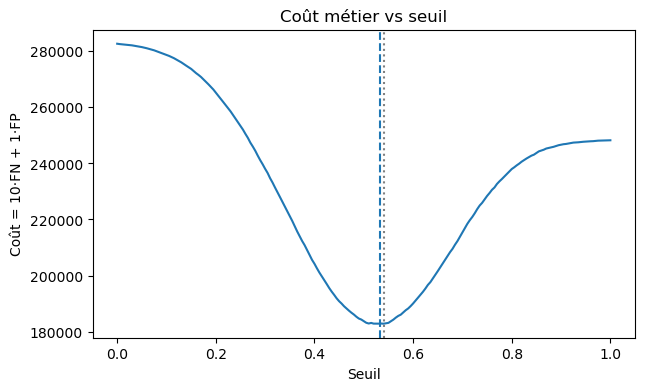

Seuil moyen CV      : 0.533
Seuil min coût (full): 0.540


In [9]:
# On récupère l'estimateur directement dans le GridSearch
import matplotlib.pyplot as plt
final_est = gs.best_estimator_
final_est.fit(X, y)

proba = get_probas(final_est, X)

ths = np.linspace(0,1,201)
costs = np.array([cost_from_threshold(y.values, proba, t, fn_cost=10.0, fp_cost=1.0) for t in ths])
t_star = ths[costs.argmin()]

plt.figure(figsize=(7,4))
plt.plot(ths, costs)
plt.axvline(FINAL_MEAN_THR, linestyle="--")
plt.axvline(t_star, color="grey", linestyle=":")
plt.title("Coût métier vs seuil")
plt.xlabel("Seuil")
plt.ylabel("Coût = 10·FN + 1·FP")
plt.show()

print(f"Seuil moyen CV      : {FINAL_MEAN_THR:.3f}")
print(f"Seuil min coût (full): {t_star:.3f}")

## 8. Comparaison des modèles

Tableau récapitulatif des performances :

| Métrique | Signification |
|----------|---------------|
| Score métier CV | Négatif du coût (plus proche de 0 = mieux) |
| AUC CV | Capacité à discriminer défaut/non-défaut (1 = parfait) |
| Seuil optimal | Seuil qui minimise le coût sur les folds |

On choisit le modèle avec le meilleur score métier (= coût le plus bas).

In [10]:
# Comparaison des modèles
results = []

# Dummy
results.append({
    'Modèle': 'DummyClassifier',
    'Score métier CV': cv_dummy['test_biz'].mean(),
    'AUC CV': cv_dummy['test_auc'].mean(),
    'Temps fit (s)': cv_dummy['fit_time'].mean(),
    'Seuil optimal': None
})

# LogReg
best_idx = gs.best_index_
results.append({
    'Modèle': 'LogReg+SVD',
    'Score métier CV': gs.cv_results_['mean_test_biz'][best_idx],
    'AUC CV': gs.cv_results_['mean_test_auc'][best_idx],
    'Temps fit (s)': gs.cv_results_['mean_fit_time'][best_idx],
    'Seuil optimal': gs.cv_results_['mean_test_thr'][best_idx]
})

# LightGBM
best_idx_lgbm = gs_lgbm.best_index_
results.append({
    'Modèle': 'LightGBM',
    'Score métier CV': gs_lgbm.cv_results_['mean_test_biz'][best_idx_lgbm],
    'AUC CV': gs_lgbm.cv_results_['mean_test_auc'][best_idx_lgbm],
    'Temps fit (s)': gs_lgbm.cv_results_['mean_fit_time'][best_idx_lgbm],
    'Seuil optimal': gs_lgbm.cv_results_['mean_test_thr'][best_idx_lgbm]
})

df_comp = pd.DataFrame(results)
print("\nCOMPARAISON MODÈLES")
print(df_comp.to_string(index=False))


COMPARAISON MODÈLES
         Modèle  Score métier CV   AUC CV  Temps fit (s)  Seuil optimal
DummyClassifier    -82750.000000 0.500000       0.252812            NaN
     LogReg+SVD    -61186.333333 0.703851      38.792271       0.533333
       LightGBM    -50600.333333 0.783746      15.046765       0.083333


## 9. Évaluation finale sur hold-out

Le score CV peut être optimiste car on a choisi les hyperparamètres dessus. Pour avoir une estimation **non biaisée**, on garde 20% des données en hold-out.

Workflow :
1. Split 80/20 stratifié
2. Entraînement sur les 80%
3. Évaluation sur les 20% (jamais vus pendant le tuning)
4. Ré-entraînement final sur 100% des données pour la production

In [11]:
# Charger X_test (les colonnes sont déjà cohérentes avec X_train depuis le feature engineering)
X_test = pd.read_parquet(X_test_path)

# Validation hold-out pour évaluation finale non biaisée
from sklearn.model_selection import train_test_split
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=7, stratify=y
)

# Entraînement sur train_final, évaluation sur holdout
final_est = gs_lgbm.best_estimator_
final_est.fit(X_train_final, y_train_final)

# Évaluation hold-out (non vue pendant CV)
proba_holdout = get_probas(final_est, X_holdout)
holdout_cost, holdout_thr = best_cost_and_threshold(y_holdout.values, proba_holdout)
holdout_auc = roc_auc_score(y_holdout, proba_holdout)
print(f"Hold-out AUC      : {holdout_auc:.4f}")
print(f"Hold-out coût     : {holdout_cost:.0f}")
print(f"Hold-out seuil opt: {holdout_thr:.3f}")

# Re-entraînement final sur tout X pour production
final_est.fit(X, y)
proba_test = get_probas(final_est, X_test)

# Distribution des probas test
print(f"\nDistribution probas test : {np.percentile(proba_test, [10, 50, 90])}")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98977
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Hold-out AUC      : 0.7871
Hold-out coût     : 30270
Hold-out seuil opt: 0.090
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98838
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 739
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 ->

## 10. Analyse de stabilité

Un bon modèle doit avoir des performances **stables** entre les folds. Si l'écart-type est trop élevé, ça veut dire que le modèle est sensible à la composition du train/test.

On affiche :
- Score moyen ± écart-type
- Écart max-min entre folds

Un écart-type < 5% du score moyen est généralement acceptable.

In [12]:
# Stabilité du score métier entre folds
splits_biz = [gs.cv_results_[f'split{i}_test_biz'][best_idx] for i in range(3)]
print(f"\nStabilité score métier : {np.mean(splits_biz):.0f} (±{np.std(splits_biz):.0f})")
print(f"Écart max/min : {max(splits_biz) - min(splits_biz):.0f}")


Stabilité score métier : -61186 (±403)
Écart max/min : 959


## 11. Interprétabilité avec SHAP

**Pourquoi SHAP ?**  
Les modèles de crédit sont soumis à des obligations réglementaires (RGPD, droit à l'explication). On doit pouvoir expliquer pourquoi un client est refusé.

**Comment ça marche ?**  
SHAP calcule la contribution de chaque feature à la prédiction finale. Une valeur SHAP positive pousse vers le défaut, négative vers le remboursement.

**TreeExplainer** est optimisé pour les modèles à base d'arbres (LightGBM, XGBoost, Random Forest). Il est beaucoup plus rapide que l'explainer générique.

On utilise un échantillon de 1000 clients pour accélérer le calcul.

In [13]:
# Installation de SHAP si nécessaire
try:
    import shap
except ImportError:
    !pip install shap --quiet
    import shap

print(f"SHAP version: {shap.__version__}")

SHAP version: 0.50.0


In [14]:
# Création de l'explainer SHAP pour LightGBM
import shap

# Échantillon de 1000 clients pour le calcul SHAP
np.random.seed(7)
sample_idx = np.random.choice(X.shape[0], size=1000, replace=False)
X_sample = X.iloc[sample_idx]

# Créer une version avec les noms de features lisibles pour SHAP
X_sample_readable = X_sample.copy()
X_sample_readable.columns = original_feature_names

# Explainer TreeSHAP (optimisé pour les modèles à base d'arbres)
explainer = shap.TreeExplainer(final_est.named_steps['clf'])
shap_values = explainer.shap_values(X_sample)

print(f"Shape des SHAP values: {shap_values.shape}")

Shape des SHAP values: (1000, 805)


C:\Users\Alexis\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


### Summary Plot - Importance globale des features

Ce graphique montre :
- **Axe Y** : les features les plus importantes (triées par impact moyen)
- **Axe X** : valeur SHAP (contribution à la prédiction)
- **Couleur** : valeur de la feature (rouge = élevée, bleu = faible)

Par exemple, si EXT_SOURCE_2 est en haut avec des points bleus à gauche et rouges à droite, ça veut dire qu'une valeur faible de EXT_SOURCE_2 augmente le risque de défaut.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_7376\2700144543.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample_readable, max_display=20, show=False)


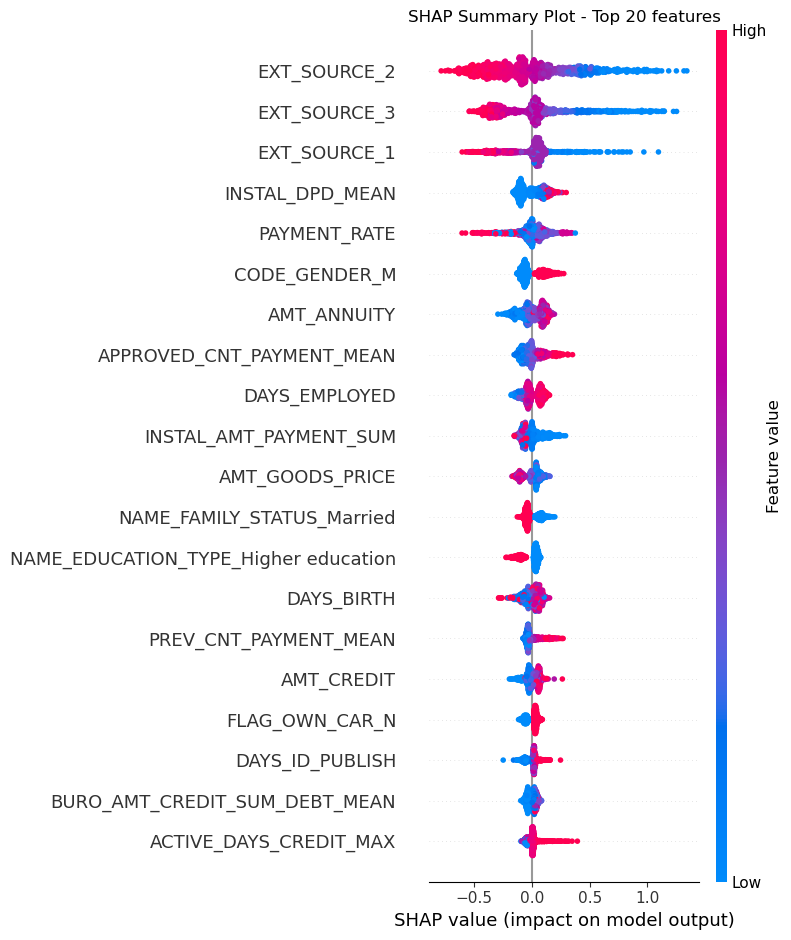

In [15]:
# Summary plot - Importance globale des features (avec noms lisibles)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample_readable, max_display=20, show=False)
plt.title("SHAP Summary Plot - Top 20 features")
plt.tight_layout()
plt.show()

### Explication individuelle - Client à haut risque

Le **waterfall plot** décompose la prédiction pour un client spécifique :
- On part de la valeur de base (proba moyenne de défaut)
- Chaque barre montre comment une feature pousse la proba vers le haut (rouge) ou le bas (bleu)
- On arrive à la prédiction finale

Ici on prend le client avec la plus haute probabilité de défaut dans notre échantillon.

Client à haut risque - Proba de défaut: 70.70%

Explication de sa prédiction:


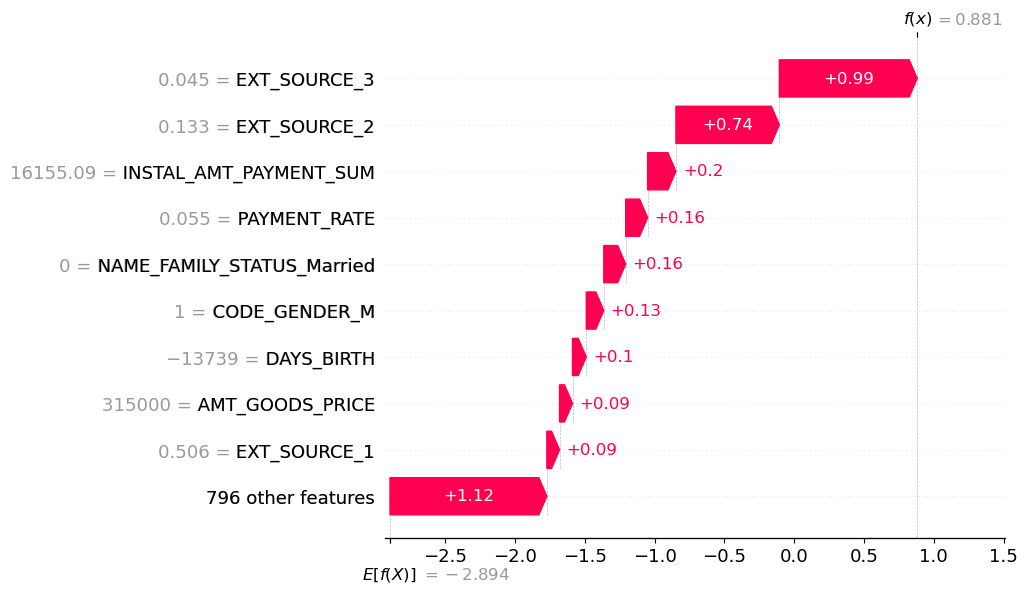

In [17]:
# Explication individuelle - Client à haut risque
proba_sample = get_probas(final_est, X_sample)
high_risk_idx = np.argmax(proba_sample)

print(f"Client à haut risque - Proba de défaut: {proba_sample[high_risk_idx]:.2%}")
print("\nExplication de sa prédiction:")

shap.waterfall_plot(shap.Explanation(
    values=shap_values[high_risk_idx],
    base_values=explainer.expected_value,
    data=X_sample_readable.iloc[high_risk_idx],
    feature_names=original_feature_names
), max_display=10)

### Comparaison avec un client à bas risque

Même analyse pour le client avec la plus faible probabilité de défaut. On devrait voir des contributions opposées sur les features clés.

Client à bas risque - Proba de défaut: 0.51%

Explication de sa prédiction:


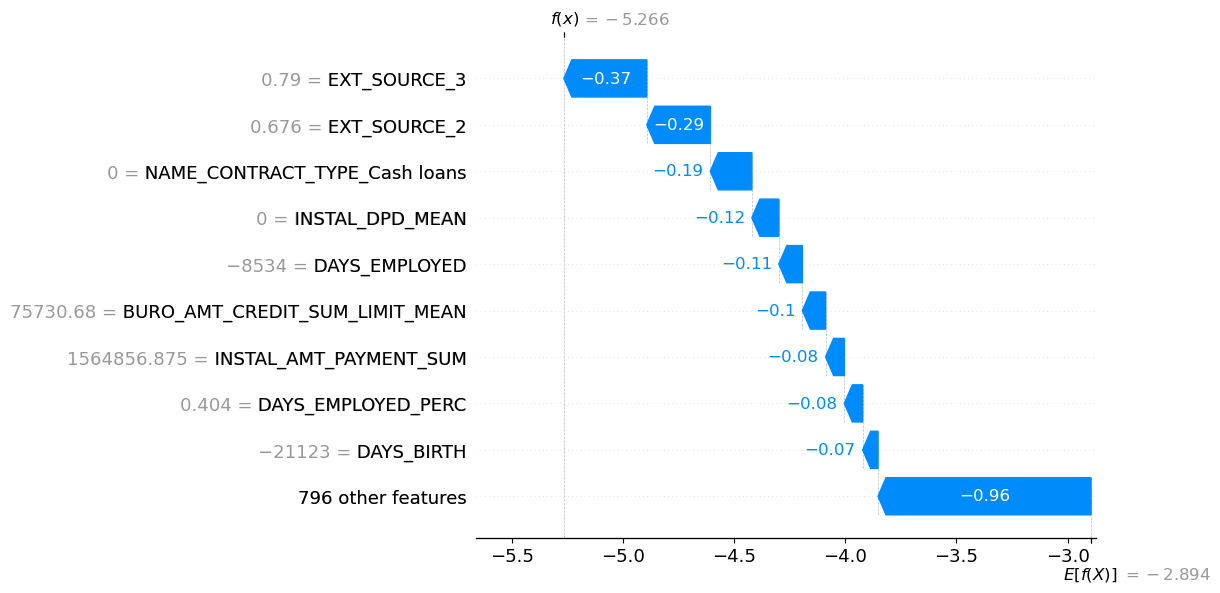

In [18]:
# Comparaison avec un client à bas risque
low_risk_idx = np.argmin(proba_sample)

print(f"Client à bas risque - Proba de défaut: {proba_sample[low_risk_idx]:.2%}")
print("\nExplication de sa prédiction:")

shap.waterfall_plot(shap.Explanation(
    values=shap_values[low_risk_idx],
    base_values=explainer.expected_value,
    data=X_sample_readable.iloc[low_risk_idx],
    feature_names=original_feature_names
), max_display=10)

## 12. Matrice de confusion

La matrice de confusion montre les 4 cas possibles :
- **TN (True Negative)** : bon client correctement accepté 
- **FP (False Positive)** : bon client refusé à tort (coût = 1)
- **FN (False Negative)** : défaut non détecté (coût = 10) 
- **TP (True Positive)** : défaut correctement détecté 

Avec notre seuil bas (~0.08), on a beaucoup de FP (prudence excessive) mais peu de FN (peu de défauts ratés). C'est voulu vu l'asymétrie des coûts.

Seuil optimal utilisé: 0.083


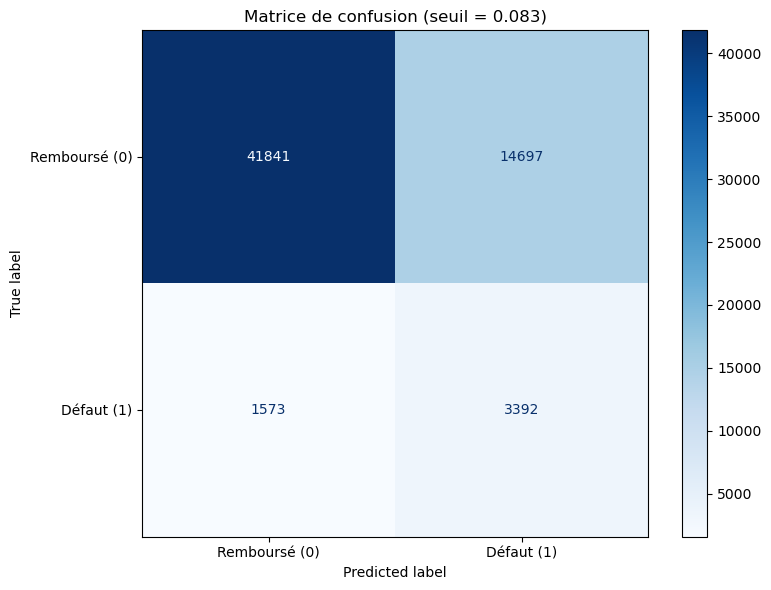


True Negatives (bons clients acceptés):  41,841
False Positives (bons clients refusés): 14,697
False Negatives (défauts ratés):        1,573
True Positives (défauts détectés):      3,392

Coût métier hold-out: 30,427


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Seuil optimal LightGBM
SEUIL_OPTIMAL = gs_lgbm.cv_results_['mean_test_thr'][gs_lgbm.best_index_]
print(f"Seuil optimal utilisé: {SEUIL_OPTIMAL:.3f}")

# Prédictions sur le hold-out avec le seuil optimal
y_pred_holdout = (proba_holdout >= SEUIL_OPTIMAL).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_holdout, y_pred_holdout)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=['Remboursé (0)', 'Défaut (1)'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Matrice de confusion (seuil = {SEUIL_OPTIMAL:.3f})')
plt.tight_layout()
plt.show()

# Extraction des valeurs
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (bons clients acceptés):  {tn:,}")
print(f"False Positives (bons clients refusés): {fp:,}")
print(f"False Negatives (défauts ratés):        {fn:,}")
print(f"True Positives (défauts détectés):      {tp:,}")
print(f"\nCoût métier hold-out: {10*fn + 1*fp:,}")

## 13. Courbes ROC et Precision-Recall

**Courbe ROC** :
- Axe X : taux de faux positifs (FPR)
- Axe Y : taux de vrais positifs (TPR = recall)
- AUC = aire sous la courbe (0.5 = aléatoire, 1 = parfait)

**Courbe Precision-Recall** :
- Plus adaptée aux classes déséquilibrées
- AP (Average Precision) résume la courbe en un chiffre

Notre AUC de ~0.78 est correcte pour ce type de problème (les données de crédit sont bruitées).

In [20]:
# Rapport de classification détaillé
print("Rapport de classification:")
print(classification_report(y_holdout, y_pred_holdout, 
                            target_names=['Remboursé', 'Défaut'],
                            digits=3))

Rapport de classification:
              precision    recall  f1-score   support

   Remboursé      0.964     0.740     0.837     56538
      Défaut      0.188     0.683     0.294      4965

    accuracy                          0.735     61503
   macro avg      0.576     0.712     0.566     61503
weighted avg      0.901     0.735     0.793     61503



### Courbe ROC et Precision-Recall

La courbe ROC montre le compromis entre taux de vrais positifs et taux de faux positifs.  
L'AUC mesure la capacité du modèle à discriminer les classes.

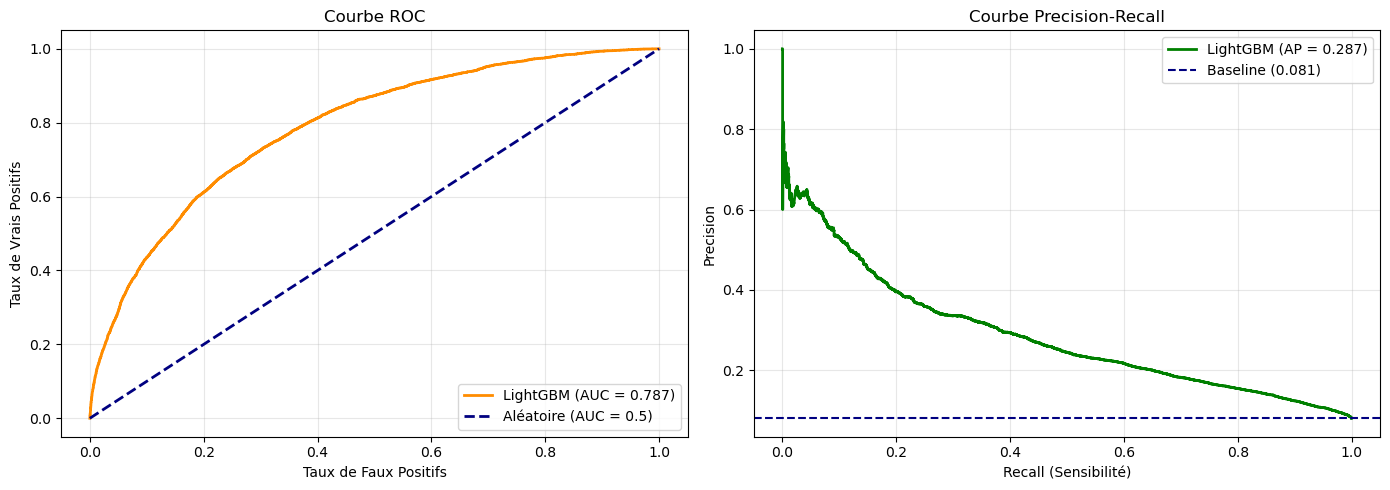

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calcul de la courbe ROC
fpr, tpr, thresholds_roc = roc_curve(y_holdout, proba_holdout)
roc_auc = auc(fpr, tpr)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'LightGBM (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (AUC = 0.5)')
axes[0].set_xlabel('Taux de Faux Positifs')
axes[0].set_ylabel('Taux de Vrais Positifs')
axes[0].set_title('Courbe ROC')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Courbe Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_holdout, proba_holdout)
ap = average_precision_score(y_holdout, proba_holdout)

axes[1].plot(recall, precision, color='green', lw=2, label=f'LightGBM (AP = {ap:.3f})')
axes[1].axhline(y=y_holdout.mean(), color='navy', linestyle='--', label=f'Baseline ({y_holdout.mean():.3f})')
axes[1].set_xlabel('Recall (Sensibilité)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Courbe Precision-Recall')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Analyse de sensibilité au seuil

On compare l'impact de différents seuils sur :
- **Coût total** : ce qu'on cherche à minimiser
- **Taux de refus** : proportion de clients refusés (FP + TP)
- **Taux de détection** : proportion de défauts détectés (recall)

Trade-off :
- Seuil bas → beaucoup de refus mais on rate peu de défauts
- Seuil haut → peu de refus mais on rate plus de défauts

Le seuil optimal est celui qui minimise le coût total compte tenu de notre fonction 10×FN + 1×FP.

In [22]:
# Analyse de différents seuils
print("Impact du choix du seuil sur les métriques:")
print("="*70)

for seuil in [0.05, 0.083, 0.10, 0.15, 0.20, 0.50]:
    y_pred = (proba_holdout >= seuil).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel()
    cout = 10*fn + fp
    taux_refus = (fp + tp) / len(y_holdout) * 100
    taux_detection = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    
    marker = " ← optimal" if abs(seuil - SEUIL_OPTIMAL) < 0.01 else ""
    print(f"Seuil {seuil:.3f}: Coût={cout:>6,} | Refus={taux_refus:>5.1f}% | Détection défauts={taux_detection:>5.1f}%{marker}")

Impact du choix du seuil sur les métriques:
Seuil 0.050: Coût=32,838 | Refus= 47.8% | Détection défauts= 84.6%
Seuil 0.083: Coût=30,446 | Refus= 29.5% | Détection défauts= 68.4% ← optimal
Seuil 0.100: Coût=30,564 | Refus= 23.9% | Détection défauts= 61.9%
Seuil 0.150: Coût=33,269 | Refus= 13.9% | Détection défauts= 45.7%
Seuil 0.200: Coût=36,039 | Refus=  8.8% | Détection défauts= 34.8%
Seuil 0.500: Coût=47,307 | Refus=  0.7% | Détection défauts=  5.0%


## Conclusion

### Modèle retenu
**LightGBM** avec seuil optimisé à ~0.08

### Performances
- AUC hold-out : ~0.78
- Coût métier optimisé selon la contrainte 10×FN + 1×FP
- Stabilité correcte entre les folds (écart-type faible)

### Interprétabilité
SHAP permet d'expliquer chaque décision :
- Les features EXT_SOURCE (scores externes) sont les plus discriminantes
- On peut générer une explication personnalisée pour chaque refus

### Limites
- Le modèle est entraîné sur des données historiques, il peut mal généraliser si le contexte économique change
- Le seuil optimal dépend du ratio de coûts FN/FP, à recalibrer si la politique de risque évolue

### Prochaines étapes
1. Déploiement via API Flask/FastAPI
2. Dashboard Streamlit pour les conseillers
3. Monitoring du data drift en production